# Modelling with TF-IDF Vectorization


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plot

In [2]:
yelp = pd.read_csv('yelp_cleaned_sentiscored.csv')
yelp.head()

,Comment,Rating,Clean_Comment,Tokenized_Comment,Lemmatized_Comment,Senti_Blob,Senti_norm
0,ich habe mir bewertungen zu restaurants auf ...,5,ich habe mir bewertungen zu restaurants auf ...,bewertungen restaurants menulist angesehen res...,ich haben sich bewertung zu restaurant auf...,1.000000,5.000000
1,das joseph ist ein ziemlich neues israelische...,4,das joseph ist ein ziemlich neues israelische...,joseph ziemlich neues israelisches restaurant ...,der joseph sein ein ziemlich neu israelisch ...,0.846429,4.692857
2,schalömchen scheiße haben wir uns heute kosche...,5,schalömchen scheiße haben wir uns heute kosche...,schalömchen scheiße heute koscher weggeknallt ...,schalömch scheiße haben wir sich heute kosch w...,0.283333,3.566667
3,essen war allenfalls ok muss ich nicht nochmal...,2,essen war allenfalls ok muss ich nicht nochmal...,essen allenfalls ok nochmal insgesamt erlebnis...,essen sein allenfalls ok mussen ich nicht noch...,0.133333,3.266667
4,waren auf empfehlung dort und wurden nicht en...,5,waren auf empfehlung dort und wurden nicht en...,empfehlung wurden enttäuscht hammer ambiente h...,sein auf empfehlung dort und werden nicht en...,0.750000,4.500000


In [3]:
# Q: https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# setting lower and upper frequency thresholds as done in reference paper Luo, Xu
# max_features: int, default=None --> If not None, build a vocabulary that only considers the top
# max_features ordered by term frequency across the corpus
# max/min_df: ignore terms that have a document frequency strictly higher/lower than given threshold
# doc_frequency=0.8
# min_absolute_frequency=5
# max_features = 15000
# norm='l2'
#tfidf = TfidfVectorizer(min_df=min_absolute_frequency, max_df=doc_frequency)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(yelp['Lemmatized_Comment'])
#print(X_tfidf)
y = yelp['Rating']
X_tfidf.shape

(9706, 38255)

## Re-sampling & Split TF-IDF dataset in train-dev-test using seed

In [4]:
from sklearn.model_selection import train_test_split
# Set a seed to guarantee same records for train, dev and test datasets are used
seed=101010

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_tfidf, y, test_size = 0.1, random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size = 0.1, random_state=seed)

### Dealing with an imbalanced Dataset: Classes 1, 2 and 3 are underrepresented in our corpus

Due to the size of the present corpus, we chose to resample the train dataset using: oversampling and combined under-and oversampling.
2 Oversampling Methods are tested below: Random Oversampler, ADASYN (Adaptive Synthetic Sampling).
SMOTETomek (SMOTE + Tomek Link Removal) was chosen for combined under-and oversampling.

Q:
https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1
https://imbalanced-learn.org/stable/references/index.html


<AxesSubplot: ylabel='Frequency'>

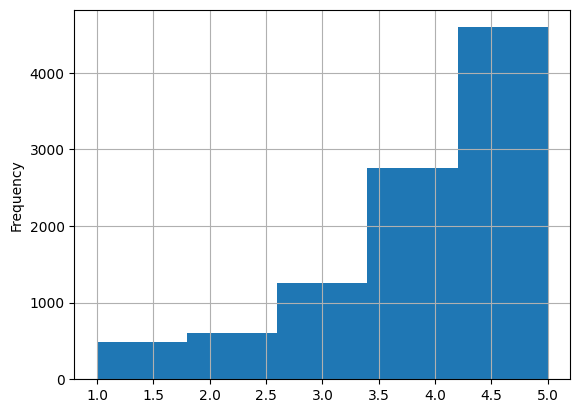

In [5]:
yelp['Rating'].plot.hist(grid=True, bins=5)

In [6]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek

In [7]:
#Random Oversampler duplicates entries for minority classes
ros = RandomOverSampler(random_state=42)
ROS_X_train, ROS_y_train = ros.fit_resample(X_train, y_train)
# Adaptive synthetic sampling generates additional data for minority class samples which are more difficult to learn
ad = ADASYN(random_state=42)
ad_X_train, ad_y_train = ad.fit_resample(X_train, y_train)

In [8]:
smtom = SMOTETomek(random_state=42)
tom_X_train, tom_y_train = smtom.fit_resample(X_train, y_train)

#### Comparison of dataset size after re-sampling


In [9]:
pd.DataFrame({'Baseline':pd.Series(y_train).value_counts(),
              'ROS':pd.Series(ROS_y_train).value_counts(),
              'ADASYN':pd.Series(ad_y_train).value_counts(),
              'SMOTETomek':pd.Series(tom_y_train).value_counts()})

,Baseline,ROS,ADASYN,SMOTETomek
1,389,3727,3757,3727
2,471,3727,3802,3727
3,1033,3727,3649,3726
4,2241,3727,4124,3722
5,3727,3727,3727,3721


#### Selection of best regression model for TF-IDF-based Prediction of "Rating"

https://www.simplilearn.com/tutorials/scikit-learn-tutorial/sklearn-regression-models

In [10]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.dummy import DummyRegressor
regressors = [LinearRegression(),
              SGDRegressor(), #Stochastic Gradient Descent Regression
              Ridge(),
              Lasso(),
              LinearSVR(),#Support Vector Machine
              DummyRegressor()]


#### All regressors will be trained using the Baseline, Oversampled, and Combined under- and oversampled train dataset

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
import time


def model_eval(xtrain,ytrain,reg_list=regressors):
    Name = []
    mae=[]
    mse = []
    maxerr=[]
    Time_Taken = []
    current_min=4
    best_model=reg_list[0] ; best_pred=[] ; best_name=LinearRegression()

    for model in reg_list:
        model = model
        name = str(model)
        Name.append(name)
        begin = time.time()
        #train
        model.fit(xtrain,ytrain)
        #validate/predict
        prediction = model.predict(X_dev)
        end = time.time()
        if mean_absolute_error(y_dev,prediction) < current_min:
            current_min = mean_absolute_error(y_dev,prediction)
            best_model = model
            best_name = name
            best_pred = prediction
        mse.append(mean_squared_error(y_dev,prediction))
        mae.append(mean_absolute_error(y_dev,prediction))
        maxerr.append(max_error(y_dev,prediction))
        Time_Taken.append(end-begin)
        print(name + ' Successfully Trained')

    Dict = {'Regressor':Name,'MAE':mae,'MSE':mse,'Max. Error':maxerr,'Time Taken':Time_Taken}
    model_df = pd.DataFrame(Dict)
    #sort by MAE for better visibility when choosing Model for Hypertuning
    model_df=model_df.sort_values(by=['MAE'], ascending=True, ignore_index=True)

    return [best_model,best_pred,best_name,model_df,mae,mse,maxerr,Time_Taken]

#### Modelling: Baseline

In [22]:
results_baseline = model_eval(xtrain = X_train, ytrain = y_train)
results_baseline[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,LinearSVR(),0.597857,0.629713,3.511573,0.264022
1,Ridge(),0.610349,0.623456,3.388318,0.073242
2,SGDRegressor(),0.819686,1.060508,2.988035,0.637374
3,Lasso(),0.872364,1.250645,3.074418,0.554698
4,DummyRegressor(),0.872364,1.250645,3.074418,0.000000
5,LinearRegression(),1.327471,2.897847,5.641654,5.618005


#### Modelling: Random Oversampler (ROS)

In [25]:
results_ros = model_eval(xtrain = ROS_X_train, ytrain = ROS_y_train)
results_ros[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.679603,0.735213,3.156796,0.262261
1,LinearSVR(),0.708544,0.805829,3.474688,1.023076
2,SGDRegressor(),0.934635,1.330458,3.519892,1.407073
3,LinearRegression(),1.321226,2.871689,5.573410,17.015326
4,Lasso(),1.430206,2.505721,2.000000,1.399795
5,DummyRegressor(),1.430206,2.505721,2.000000,0.000000


#### Modelling: ADASYN

In [26]:
results_adasyn = model_eval(xtrain = ad_X_train, ytrain = ad_y_train)
results_adasyn[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.664620,0.709662,3.188193,0.715083
1,LinearSVR(),0.707114,0.802090,3.368464,10.165813
2,SGDRegressor(),0.937379,1.344807,3.379811,2.314366
3,LinearRegression(),1.321913,2.870677,5.567950,34.115147
4,Lasso(),1.422530,2.475082,2.013747,1.938818
5,DummyRegressor(),1.422530,2.475082,2.013747,0.000000


#### Modelling: SMOTETomek

In [15]:
results_smote = model_eval(xtrain = tom_X_train, ytrain = tom_y_train)
results_smote[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.662040,0.709892,3.227537,0.610214
1,LinearSVR(),0.698229,0.797059,3.323790,9.086921
2,SGDRegressor(),0.932411,1.334309,3.388200,2.198039
3,LinearRegression(),1.313952,2.826148,5.425868,30.862370
4,Lasso(),1.430912,2.507769,2.000913,1.678803
5,DummyRegressor(),1.430912,2.507769,2.000913,0.000000


Text(0.5, 1.0, 'Distribution of predictions compared to rating for Ridge()')

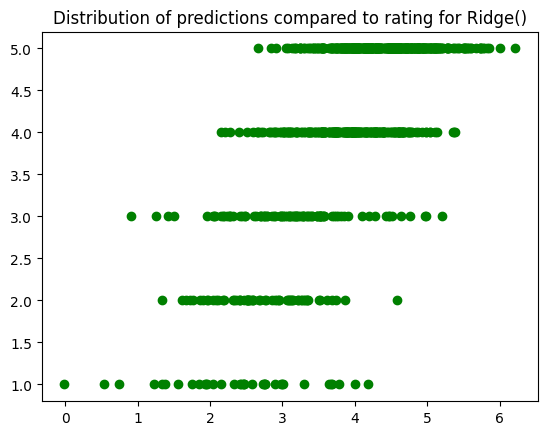

In [29]:
#predictions for best model
plot.plot(results_adasyn[1], y_dev, 'o', color='green')
plot.title(label=str("Distribution of predictions compared to rating for "+results_adasyn[2]))

Text(0.5, 1.0, 'Distribution of predictions compared to rating for LinearSVR()')

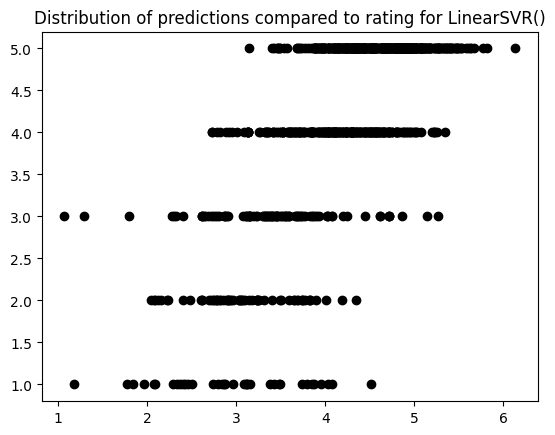

In [30]:
plot.plot(results_baseline[1], y_dev, 'o', color='black')
plot.title(label=str("Distribution of predictions compared to rating for "+results_baseline[2]))

Text(0.5, 1.0, 'Distribution of predictions compared to rating for Ridge()')

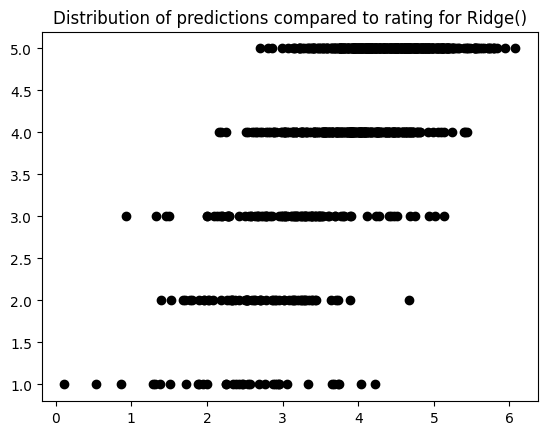

In [31]:
plot.plot(results_smote[1], y_dev, 'o', color='black')
plot.title(label=str("Distribution of predictions compared to rating for "+results_smote[2]))